In [1]:
import torch
import numpy as np
import math
import os
import pytorch_lightning as pl
import torch
from hydra.utils import instantiate
import matplotlib.pyplot as plt
from case_studies.redshift_estimation.catalog import RedshiftFullCatalog, RedshiftTileCatalog
from bliss.encoder.plotting import plot_detections, my_plot_detections
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from einops import rearrange, reduce, repeat
import pandas as pd

In [2]:
from os import environ
environ["CUDA_VISIBLE_DEVICES"] = "4"

from pathlib import Path
from hydra import initialize, compose
from bliss.main import predict

environ["BLISS_HOME"] = str("/home/declan/current/bliss")

In [3]:
with initialize(config_path="../", version_base=None):
    cfg = compose("redshift", {
        "predict.weight_save_path=/data/scratch/declan/sdss_encoder_ckpt.ckpt",
        "cached_simulator.cached_data_path=/data/scratch/declan/sdss_like_galaxies"
        })

In [4]:
pl.seed_everything(cfg.train.seed)

Global seed set to 42


42

In [5]:
sdss_photo_z = pd.read_csv('/data/scratch/declan/GALAXY.csv')

In [6]:
sdss_photo_z.head(10)

,Unnamed: 0,objID,u_band,g_band,r_band,i_band,z_band,redshift,source_type
0,1,1237648720142401611,17.15123,15.49701,14.67864,14.23418,13.90272,0.021222,GALAXY
1,2,1237650795146510627,21.33301,19.13112,17.71233,17.14911,16.76272,0.203783,GALAXY
2,4,1237650795146445031,19.50005,17.59248,16.67668,16.20502,15.84654,0.064656,GALAXY
3,5,1237648720142401670,19.48419,18.32629,17.84381,17.52679,17.42098,0.052654,GALAXY
4,6,1237648720142532891,20.43564,18.65154,17.46877,17.00000,16.66850,0.213861,GALAXY
5,7,1237650795146510903,25.33996,21.41559,19.63294,18.82156,18.31593,0.448220,GALAXY
6,8,1237648720142401774,22.21115,20.35695,18.53198,17.95600,17.54655,0.371128,GALAXY
7,9,1237650795146576091,19.95617,17.99290,16.84732,16.36030,15.94058,0.121271,GALAXY
8,10,1237650795146641532,20.32049,18.50948,17.61596,17.20631,16.90706,0.097086,GALAXY
9,12,1237650795146576030,20.77635,18.64786,17.30996,16.71203,16.22114,0.126590,GALAXY


In [7]:
x = sdss_photo_z.values[:,2:7]
y = sdss_photo_z.values[:,7]

In [8]:
from tqdm import tqdm

class Regressor(torch.nn.Module):
    def __init__(
        self, in_dim, hidden_dim, out_dim, device
    ):
        super().__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.device = device
        self.loss_fcn = nn.MSELoss()

        self.dense = torch.nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )
        
        self.optimizer = torch.optim.Adam(self.dense.parameters(), lr=1e-3)

    def forward(self, photometry):
        return self.dense(photometry)
    
    def train_one_epoch(self, dataloader):
        losses = []
        for idx, (x, y) in tqdm(enumerate(dataloader), unit='batch'):
            x = x.to(self.device)
            y = y.to(self.device)
            self.optimizer.zero_grad()
            loss = self.loss_fcn(self.dense(x).view(-1), y)
            loss.backward()
            self.optimizer.step()
            
            losses.append(loss.item())
            
        return torch.tensor(losses).mean()
    
    def train(self, dataloader, n_epochs=100):
        for i in range(n_epochs):
            this_epoch_average_loss = self.train_one_epoch(dataloader)
            print('Epoch {}: Avg. Loss {}'.format(i, this_epoch_average_loss))

In [9]:
x = x.astype(float)
y = y.astype(float)

In [10]:
from torch.utils.data import TensorDataset, DataLoader

# use x_train and y_train as numpy array without further modification
x_train = np.array(x)
y_train = np.array(y)

# convert to numpys to tensor
tensor_x = torch.Tensor(x_train) 
tensor_y = torch.Tensor(y_train)
# create the dataset
custom_dataset = TensorDataset(tensor_x,tensor_y) 
# create your dataloader
train_dataloader = DataLoader(custom_dataset,batch_size=2048) 

In [11]:
reg = Regressor(5, 256, 1, 'cuda')
reg = reg.to('cuda')

In [12]:
reg.train(train_dataloader, n_epochs=10)

418batch [00:16, 24.80batch/s]


Epoch 0: Avg. Loss 0.036019641906023026


418batch [00:14, 29.54batch/s]


Epoch 1: Avg. Loss 0.004865583498030901


418batch [00:10, 38.39batch/s]


Epoch 2: Avg. Loss 0.0038388564717024565


418batch [00:10, 40.87batch/s]


Epoch 3: Avg. Loss 0.002813660306856036


418batch [00:11, 36.96batch/s]


Epoch 4: Avg. Loss 0.002674606628715992


418batch [00:14, 29.32batch/s]


Epoch 5: Avg. Loss 0.002406184794381261


418batch [00:12, 33.40batch/s]


Epoch 6: Avg. Loss 0.0022849238011986017


418batch [00:10, 41.30batch/s]


Epoch 7: Avg. Loss 0.0022694298531860113


418batch [00:13, 31.45batch/s]


Epoch 8: Avg. Loss 0.0020379466004669666


418batch [00:10, 41.32batch/s]

Epoch 9: Avg. Loss 0.002096329815685749


In [13]:
preds = []
trues = []
for idx, (x, y) in tqdm(enumerate(train_dataloader), unit='batch'):
    x = x.to(reg.device)
    y = y.to(reg.device)
    pred_this_batch = reg.dense(x)
    preds.append(pred_this_batch)
    trues.append(y)
    

    if idx > 100:
        break

101batch [00:02, 35.65batch/s]


In [14]:
preds = torch.cat(preds)
trues = torch.cat(trues)

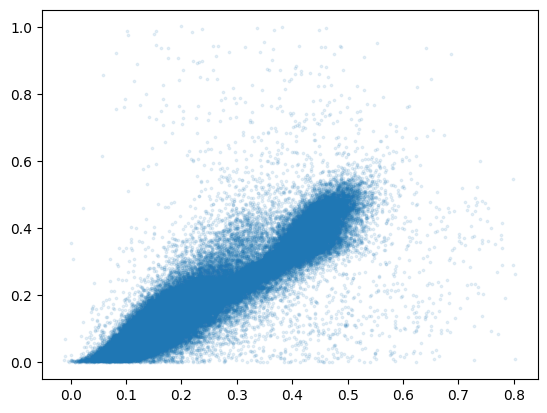

In [15]:
plt.scatter(preds.detach().cpu().numpy(), trues.detach().cpu().numpy(), alpha=0.1, s=3)

In [16]:
preds.shape

torch.Size([208896, 1])

In [ ]:
# This cell will take some time to run to load the dataset
pl.seed_everything(cfg.train.seed)

# setup dataset and encoder
dataset = instantiate(cfg.train.data_source)
encoder = instantiate(cfg.train.encoder)

In [ ]:
bliss_train_dataloader = dataset.train_dataloader() 
batch = next(iter(bliss_train_dataloader))
print('Batch of images is of shape {}'.format(batch['images'].shape))

In [ ]:
batch['tile_catalog'].keys()

In [ ]:
fluxes_used = batch['tile_catalog']['galaxy_fluxes']
redshifts_used = batch['tile_catalog']['redshifts']

In [ ]:
fluxes_used = rearrange(fluxes_used, 'b w h 1 d -> (b w h) d')
redshifts_used = rearrange(redshifts_used, 'b w h 1 d -> (b w h) d')

In [ ]:
observations = torch.cat([fluxes_used, redshifts_used], axis=-1)

In [ ]:
observations

These observations should have been drawn from rows of GALAXY.csv, is my understanding.

In [ ]:
cfg.train.data_source

In [ ]:
sdss_photo_z.head(10)

In [ ]:
observations[:,-1].max()

In [ ]:
torch.where(observations[:,-1] > 0.934)

In [ ]:
observations[10368]

In [ ]:
sdss_photo_z[(sdss_photo_z['redshift'] > 0.9345) & (sdss_photo_z['redshift'] < 0.9347)]

Not looking promising....let's draw from a random dataset?

In [ ]:
dataset = torch.load("/data/scratch/declan/sdss_like_galaxies/dataset_0.pt")

In [ ]:
this_image_fluxes = dataset[0]['tile_catalog']['galaxy_fluxes']
this_image_redshifts = dataset[0]['tile_catalog']['redshifts']

In [ ]:
this_image_fluxes = rearrange(this_image_fluxes, 'h w 1 d -> (h w) d')
this_image_redshifts = rearrange(this_image_redshifts, 'h w 1 d -> (h w) d')

In [ ]:
image_0 = torch.cat([this_image_fluxes, this_image_redshifts], -1)

In [ ]:
image_0[:,-1].max().item()

In [ ]:
torch.where(image_0[:,-1] > .5734093)

In [ ]:
image_0[269]

In [ ]:
sdss_photo_z[(sdss_photo_z['redshift'] > 0.5734093) & (sdss_photo_z['redshift'] < 0.5735)]

### Clearly there is an issue with the prior construction. Let's investigate (sigh)

In [7]:
my_prior = instantiate(cfg.prior)

In [10]:
cat = my_prior.sample()
cat = cat.to_dict()

In [12]:
cat.keys()

dict_keys(['locs', 'n_sources', 'source_type', 'galaxy_fluxes', 'galaxy_params', 'star_fluxes', 'redshifts'])

In [13]:
this_image_fluxes = cat['galaxy_fluxes']
this_image_redshifts = cat['redshifts']

In [14]:
this_image_fluxes = rearrange(this_image_fluxes, 'b h w 1 d -> (b h w) d')
this_image_redshifts = rearrange(this_image_redshifts, 'b h w 1 d -> (b h w) d')

In [15]:
all_objects = torch.cat([this_image_fluxes, this_image_redshifts], -1)

In [16]:
all_objects

tensor([[19.0288, 17.8080, 17.3356, 17.0279, 16.8469,  0.0660],
        [18.2855, 16.4914, 15.7722, 15.4235, 15.1650,  0.0632],
        [20.7746, 19.5998, 18.6912, 18.2078, 17.8561,  0.1164],
        ...,
        [20.2237, 18.0903, 17.0952, 16.6836, 16.3568,  0.0904],
        [19.9456, 18.2042, 17.2599, 16.8588, 16.4916,  0.1353],
        [19.2419, 17.2537, 16.2417, 15.7919, 15.4254,  0.1132]])

In [17]:
all_objects[:,-1].max().item()

0.9982324838638306

In [18]:
torch.where(all_objects[:,-1] > .998)

(tensor([3169]),)

In [19]:
all_objects[3169]

tensor([21.5009, 21.1751, 20.5881, 19.9058, 19.3929,  0.9982])

In [20]:
sdss_photo_z[(sdss_photo_z['redshift'] > 0.998) & (sdss_photo_z['redshift'] < 0.999)]

,Unnamed: 0,objID,u_band,g_band,r_band,i_band,z_band,redshift,source_type
166041,195529,1237666408438694159,21.50090,21.17512,20.58808,19.90579,19.39288,0.998232,GALAXY
807272,993907,1237657587095896105,24.07526,24.15117,22.57249,21.48528,22.22804,0.998233,GALAXY


In [ ]:
from omegaconf import DictConfig, OmegaConf

In [ ]:
my_dict = OmegaConf.to_container(cfg.prior)

In [ ]:
my_dict.pop('_target_')

In [ ]:
yo = RedshiftCSVPrior_Galaxy(**my_dict)

In [ ]:
yo._sample_indices()

In [ ]:
latent_dims = (32, 20, 20, 1, 1)

In [ ]:
array = (
            pd.read_csv(
                "/data/scratch/declan/GALAXY.csv",
                header=0,
                dtype={
                    "u_band": float,
                    "g_band": float,
                    "r_band": float,
                    "i_band": float,
                    "z_band": float,
                    "redshift": float,
                },
            )
            .to_numpy()[:, 2:8]
            .astype(float)
        )

In [ ]:
indices = np.random.choice(range(len(array)), size=latent_dims, replace=True)

In [ ]:
indices.shape

In [ ]:
redshifts = torch.from_numpy(np.take(array[:, -1], indices))

In [ ]:
redshifts[0,0,0]

In [ ]:
indices[0,0,0]

In [ ]:
array[838932]

In [ ]:
dataset[0].keys()

In [ ]:
dataset[1].keys()

In [ ]:
type(dataset[0])

In [ ]:
dataset

In [ ]:
fluxes_used.shape, redshifts_used.shape

In [ ]:
n_to_show = 10
_, axs = plt.subplots(10, 5, figsize=(12,24))
axs = axs.flatten()
imgs = batch['images'][:10].flatten(start_dim=0,end_dim=1)
for img, ax in zip(imgs, axs):
    ax.imshow(img)
    
for a in axs:
    a.set_xticklabels([])
    a.set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()